In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Wed Jan 17 17:50:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   35C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 462304
-rw-rw-r-- 1 scpark scpark     29753  1월 17 17:50 events.out.tfevents.1705481296.GPUSVR11
-rw-rw-r-- 1 scpark scpark 473276127  1월 17 17:48 save_0
-rw-rw-r-- 1 scpark scpark     58271  1월 17 17:47 events.out.tfevents.1705480992.GPUSVR11
-rw-rw-r-- 1 scpark scpark     14912  1월 17 17:43 events.out.tfevents.1705480855.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

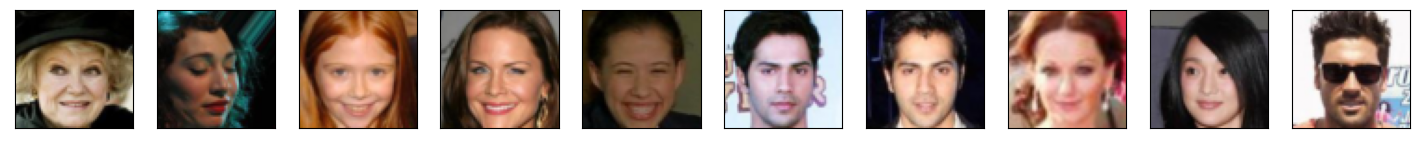

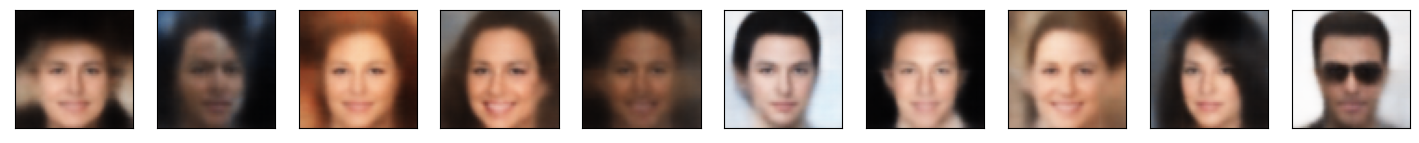

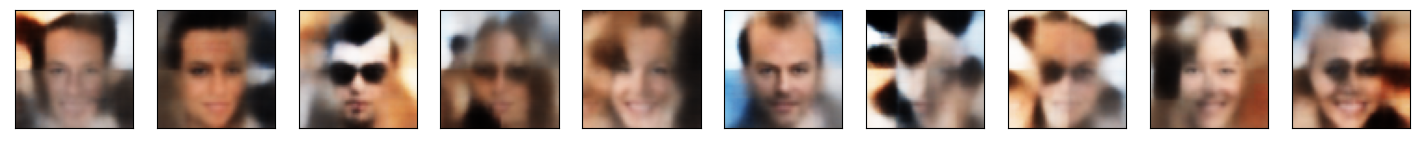

11001
swae_loss 0.030457044206559657
recon_loss 0.010850952751934529
11002
swae_loss 0.032103225216269494
recon_loss 0.010711112152785062
11003
swae_loss 0.03150499761104584
recon_loss 0.011274359840899705
11004
swae_loss 0.03232582230120897
recon_loss 0.011342674493789673
11005
swae_loss 0.03148232586681843
recon_loss 0.010854969825595617
11006
swae_loss 0.03106869142502546
recon_loss 0.01091359294950962
11007
swae_loss 0.031768064573407175
recon_loss 0.01071332637220621
11008
swae_loss 0.036796530708670616
recon_loss 0.011253439541906118
11009
swae_loss 0.031108872033655643
recon_loss 0.010820512380450963
11010
swae_loss 0.03148352764546871
recon_loss 0.011310656368732453
11011
swae_loss 0.03197566401213407
recon_loss 0.010889285337179899
11012
swae_loss 0.031602241285145286
recon_loss 0.010997136868536473
11013
swae_loss 0.03120710887014866
recon_loss 0.010909669380635024
11014
swae_loss 0.032302291691303255
recon_loss 0.01037550400942564
11015
swae_loss 0.03379759881645441
recon_lo

11122
swae_loss 0.031169608421623706
recon_loss 0.010920946672558784
11123
swae_loss 0.029893963038921355
recon_loss 0.010591758694499732
11124
swae_loss 0.030113323405385018
recon_loss 0.010999892558902501
11125
swae_loss 0.033020060136914255
recon_loss 0.010923529416322708
11126
swae_loss 0.03274225872009993
recon_loss 0.010861328337341547
11127
swae_loss 0.03229781687259674
recon_loss 0.010896770935505628
11128
swae_loss 0.03147924151271582
recon_loss 0.010994832497090101
11129
swae_loss 0.03231523595750332
recon_loss 0.010849016439169645
11130
swae_loss 0.033447472378611565
recon_loss 0.01148624150082469
11131
swae_loss 0.03143076039850712
recon_loss 0.011270551942288876
11132
swae_loss 0.03266562726348639
recon_loss 0.01092659831047058
11133
swae_loss 0.03273456394672394
recon_loss 0.011209421511739492
11134
swae_loss 0.033775383979082106
recon_loss 0.01064830543473363
11135
swae_loss 0.031156535260379314
recon_loss 0.011172281298786401
11136
swae_loss 0.03317263051867485
recon_lo

11243
swae_loss 0.030281206406652928
recon_loss 0.010846713185310363
11244
swae_loss 0.032120352424681184
recon_loss 0.01064451402053237
11245
swae_loss 0.03201649598777294
recon_loss 0.010672982409596443
11246
swae_loss 0.02960766516625881
recon_loss 0.010813663899898528
11247
swae_loss 0.031067989580333234
recon_loss 0.011129091866314412
11248
swae_loss 0.033125877007842065
recon_loss 0.010768781416118145
11249
swae_loss 0.03365714978426695
recon_loss 0.011127707920968533
11250
swae_loss 0.0334274785593152
recon_loss 0.011056770849972964
11251
swae_loss 0.033937417529523374
recon_loss 0.010447081085294485
11252
swae_loss 0.03353663440793753
recon_loss 0.010220825579017401
11253
swae_loss 0.03282385841012001
recon_loss 0.0108735091984272
11254
swae_loss 0.031932007148861886
recon_loss 0.010680633224546909
11255
swae_loss 0.031871421821415426
recon_loss 0.010709138214588165
11256
swae_loss 0.03149259276688099
recon_loss 0.010304774902760983
11257
swae_loss 0.031089335307478906
recon_lo

11364
swae_loss 0.031532971374690535
recon_loss 0.010943352431058883
11365
swae_loss 0.031190739944577217
recon_loss 0.011201464291661977
11366
swae_loss 0.03202391751110554
recon_loss 0.011213035322725773
11367
swae_loss 0.03295461051166058
recon_loss 0.011160205863416196
11368
swae_loss 0.03244384229183197
recon_loss 0.01065969057381153
11369
swae_loss 0.031608447805047034
recon_loss 0.010705972369760276
11370
swae_loss 0.032872816734015944
recon_loss 0.010954250767827033
11371
swae_loss 0.03324397224932909
recon_loss 0.01053448598831892
11372
swae_loss 0.03398848734796047
recon_loss 0.01059320494532585
11373
swae_loss 0.03110420946031809
recon_loss 0.010749340616166591
11374
swae_loss 0.03258722815662622
recon_loss 0.01110098510980606
11375
swae_loss 0.033545558154582975
recon_loss 0.010661509446799755
11376
swae_loss 0.030826780758798123
recon_loss 0.011217868700623513
11377
swae_loss 0.03270122744143009
recon_loss 0.01080709844827652
11378
swae_loss 0.031279281713068485
recon_loss

11485
swae_loss 0.03258362039923668
recon_loss 0.011225577630102634
11486
swae_loss 0.031566067971289156
recon_loss 0.011173181515187026
11487
swae_loss 0.03227930795401335
recon_loss 0.011121757514774799
11488
swae_loss 0.03192485775798559
recon_loss 0.010884301085025073
11489
swae_loss 0.03328660540282726
recon_loss 0.010396715719252825
11490
swae_loss 0.031178032606840135
recon_loss 0.010381805896759033
11491
swae_loss 0.03105736281722784
recon_loss 0.010493364930152894
11492
swae_loss 0.03201762884855271
recon_loss 0.01061073997989297
11493
swae_loss 0.03141529690474272
recon_loss 0.011016790010035037
11494
swae_loss 0.0331824803724885
recon_loss 0.011052646860480308
11495
swae_loss 0.03304648790508509
recon_loss 0.010980854090303183
11496
swae_loss 0.03019107785075903
recon_loss 0.01056597763672471
11497
swae_loss 0.03226934298872948
recon_loss 0.010703138820827008
11498
swae_loss 0.02949451971799135
recon_loss 0.010517009347677232
11499
swae_loss 0.03226850107312203
recon_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        